In [357]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import signal
from skimage.feature import match_template
from skimage import color, io, filters

import cv2
plt.gray()
%matplotlib inline

# Correlation-based Motion Detection

This notebook explores using template matching to detect motion. The idea is that if we have two images, $I_1$ and $I_2$, where $I_1$ is captured shortly before $I_2$, then we can estimate the motion between the images by taking a template in $I_1$, and seeing where it appears in $I_2$. If the time difference is small enough, then the features will look pretty similar (almost the same size and rotation), so we can try to use a standard template matching procedure (locally). In this case, we use correlation to try to match a $5\times 5$ reference patch to a $15\times 15$ patch about the same pixel in $I_2$. We then see how what location results in the highest response (somewhere from $-7$ to 7 inclusive), and then we take the displacement as the motion vector. This has the obvious issue that if there is more than 5 pixel motion or so, it might not be as effective at tracking. I also experimented with normalized cross-correlation, because of the issues in areas of differing brightness when using plain correlations.

From the results, we can see that with correlation, this method is quite ineffective. The optical flow is determined to be directed towards the brighter patches, because they will have higher response by default. If we change this to use normalized cross-correlation, we can see an instant improvement. Although the flow vectors are not particularly smooth, they do seem to be approximately in the correct direction and magnitude. Note that I do not account for the aperture problem here, so if we have a square moving down right, the edge is ambiguous and there is equal response from each location, so the argmax chosen will not necessarily be where one might expect. Only the corner is properly detected, as it has two edges to match.

In [373]:
files = sorted(glob.glob('./data/image/seq1/*.png'), key=lambda x: int(x.split('/')[-1][5:-4]))
files = sorted(glob.glob('./data/sphere/sphere.*.png'), key=lambda x: int(x.split('/')[-1].split('.')[-2]))
# files = sorted(glob.glob('./data/rubic/rubic.*.png'), key=lambda x: int(x.split('/')[-1].split('.')[-2]))
# files

In [196]:
im1, im2 = plt.imread(files[0]).astype(np.float32), plt.imread(files[2]).astype(np.float32)
im1, im2 = color.rgb2gray(im1), color.rgb2gray(im2)

In [210]:
im1 = np.ones((256,256))
im1[:128, :128] = 0
im2 = np.ones((256,256))
im2[:129, :129] = 0

In [369]:
def dw_corr(im, template):
    return signal.correlate2d(im, template, 'valid')

def find_vectors(im1, im2, step_size=5, ref_size=5, region_size=15, use_corr=False):
    assert im1.shape==im2.shape
    r = ref_size // 2
    rr = region_size // 2

    outputs = np.zeros((im1.shape[0]//step_size+1, im1.shape[1]//step_size+1, 4))
    n, m = im1.shape
    
    for i in range(rr, n-rr, step_size):
        for j in range(rr, m-rr, step_size):
            ref = im1[max(0, i-r):min(i+r+ref_size%2, n), max(0, j-r):min(j+r+ref_size%2, m)]
            reg = im2[max(0, i-rr):min(i+rr+region_size%2, n), max(0, j-rr):min(j+rr+region_size%2, m)]
#             if use_corr:
            if np.allclose(ref, im2[max(0, i-r):min(i+r+ref_size%2, n), max(0, j-r):min(j+r+ref_size%2, m)]):
                bx=by=0
            else:
                if use_corr:
                    res = dw_corr(reg, ref)
                else:
                    res = match_template(reg, ref)                
                by, bx = np.unravel_index(res.argmax(), res.shape)
                by += r -rr
                bx += r -rr
            outputs[i//step_size,j//step_size,:] = (j, i, bx, -by)
    outputs = outputs.reshape(-1,4)
    return outputs

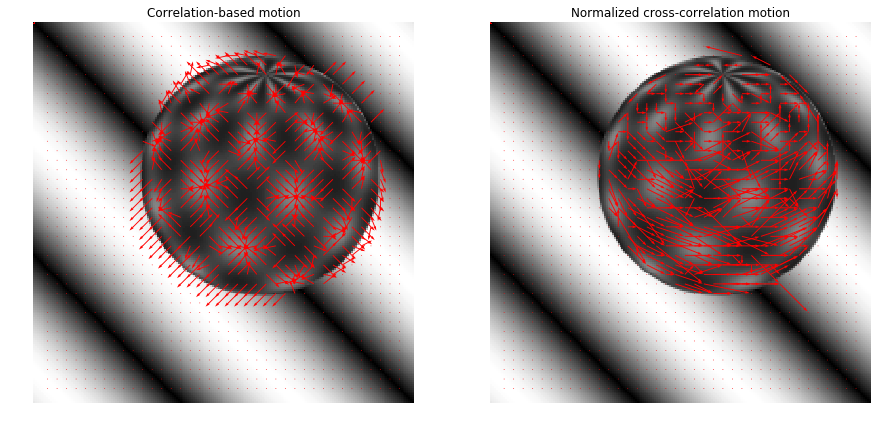

In [370]:
files = sorted(glob.glob('./data/sphere/sphere.*.png'), key=lambda x: int(x.split('/')[-1].split('.')[-2]))
im1, im2 = io.imread(files[0], True), io.imread(files[1], True)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title('Correlation-based motion')
outputs = find_vectors(im1, im2, 5, 5, 15, True)
plt.imshow(im1)
plt.quiver(*outputs.T, color='r')
plt.axis('off');

plt.subplot(1,2,2)
plt.title('Normalized cross-correlation motion')
outputs = find_vectors(im1, im2, 5, 5, 15, False)
plt.imshow(im1)
plt.quiver(*outputs.T, color='r')
plt.axis('off');

## Correlation motion detection

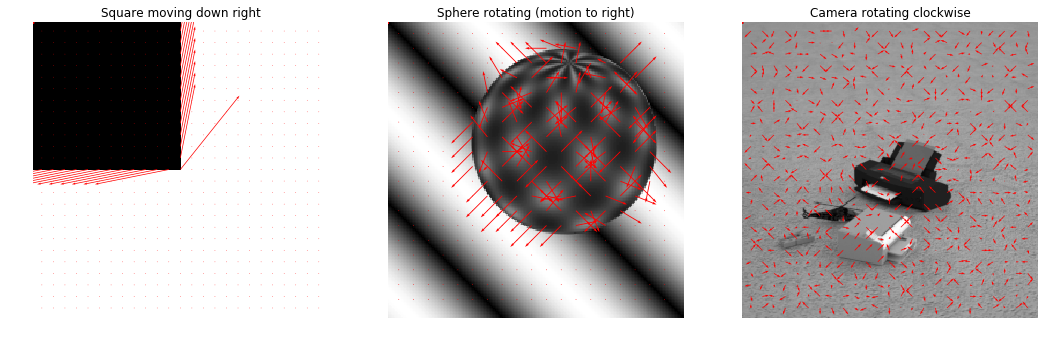

In [371]:
plt.figure(figsize=(18,6))
# plt.gca().invert_yaxis()
plt.subplot(1,3,1)
plt.title('Square moving down right')
im1 = np.ones((256,256))
im1[:128, :128] = 0
im2 = np.ones((256,256))
im2[:129, :129] = 0
outputs = find_vectors(im1, im2, 10, 5, 15, True)
plt.imshow(im1)
plt.quiver(*outputs.T, color='r', scale=20)
plt.axis('off');

plt.subplot(1,3,2)
plt.title('Sphere rotating (motion to right)')
files = sorted(glob.glob('./data/sphere/sphere.*.png'), key=lambda x: int(x.split('/')[-1].split('.')[-2]))
im1, im2 = io.imread(files[0], True), io.imread(files[1], True)
outputs = find_vectors(im1, im2, 10, 5, 15, True)
plt.imshow(im1)
plt.quiver(*outputs.T, color='r')
plt.axis('off');

plt.subplot(1,3,3)
plt.title('Camera rotating clockwise')
files = sorted(glob.glob('./data/image/seq1/*.png'), key=lambda x: int(x.split('/')[-1][5:-4]))
im1, im2 = io.imread(files[0], True), io.imread(files[1], True)
outputs = find_vectors(im1, im2, 10, 5, 15, True)
plt.imshow(im1)
plt.quiver(*outputs.T, color='r')
plt.axis('off');

## Normalized Cross-correlation

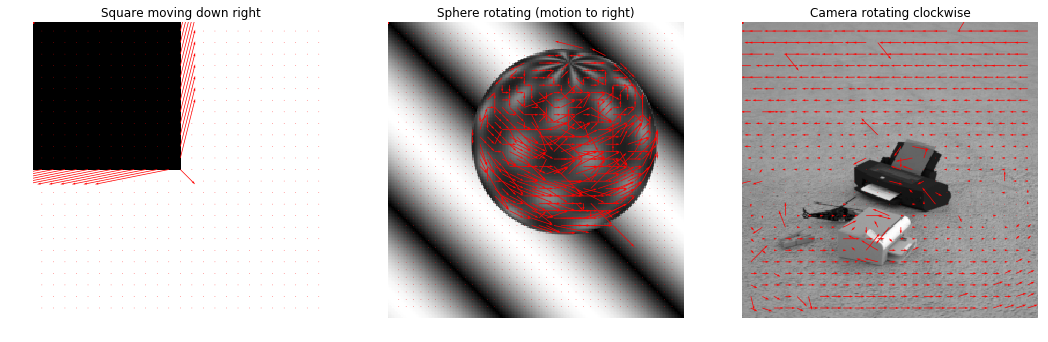

In [372]:
plt.figure(figsize=(18,6))
# plt.gca().invert_yaxis()
plt.subplot(1,3,1)
plt.title('Square moving down right')
im1 = np.ones((256,256))
im1[:128, :128] = 0
im2 = np.ones((256,256))
im2[:129, :129] = 0
outputs = find_vectors(im1, im2, 10, 5, 15, False)
plt.imshow(im1)
plt.quiver(*outputs.T, color='r', scale=20)
plt.axis('off');

plt.subplot(1,3,2)
plt.title('Sphere rotating (motion to right)')
files = sorted(glob.glob('./data/sphere/sphere.*.png'), key=lambda x: int(x.split('/')[-1].split('.')[-2]))
im1, im2 = io.imread(files[0], True), io.imread(files[1], True)
outputs = find_vectors(im1, im2, 5, 5, 15, False)
plt.imshow(im1)
plt.quiver(*outputs.T, color='r')
plt.axis('off');

plt.subplot(1,3,3)
plt.title('Camera rotating clockwise')
files = sorted(glob.glob('./data/image/seq1/*.png'), key=lambda x: int(x.split('/')[-1][5:-4]))
im1, im2 = io.imread(files[0], True), io.imread(files[1], True)
outputs = find_vectors(im1, im2, 10, 5, 15, False)
plt.imshow(im1)
plt.quiver(*outputs.T, color='r')
plt.axis('off');